# Natality Model using Catboost

In [1]:
# @title Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table
from google.cloud import storage

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import catboost
import pickle

project = '' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

### Reading data

In [ ]:
query = "select * from `bigquery-public-data.samples.natality` TABLESAMPLE SYSTEM (.01 PERCENT)"
results = pd.read_gbq(query)

In [ ]:
results.columns

Index(['source_year', 'year', 'month', 'day', 'wday', 'state', 'is_male',
       'child_race', 'weight_pounds', 'plurality', 'apgar_1min', 'apgar_5min',
       'mother_residence_state', 'mother_race', 'mother_age',
       'gestation_weeks', 'lmp', 'mother_married', 'mother_birth_state',
       'cigarette_use', 'cigarettes_per_day', 'alcohol_use', 'drinks_per_week',
       'weight_gain_pounds', 'born_alive_alive', 'born_alive_dead',
       'born_dead', 'ever_born', 'father_race', 'father_age', 'record_weight'],
      dtype='object')

### Data Preparation

In [ ]:
results = results.loc[results['weight_pounds'].notna()]

In [ ]:
results = results.sample(n=10000,random_state=42)

In [ ]:
X_columns = ['plurality','mother_age','father_age','ever_born','cigarettes_per_day','drinks_per_week','weight_gain_pounds']

In [ ]:
X = results[X_columns].astype(float).fillna(0)

In [ ]:
y = results['weight_pounds']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Building model

In [ ]:
my_model = catboost.CatBoostRegressor()

In [ ]:
my_model.fit(X=X_train, y=y_train)

Learning rate set to 0.055297
0:	learn: 1.3264899	total: 48.5ms	remaining: 48.5s
1:	learn: 1.3202643	total: 50.6ms	remaining: 25.2s
2:	learn: 1.3142711	total: 54.9ms	remaining: 18.2s
3:	learn: 1.3093380	total: 58.4ms	remaining: 14.5s
4:	learn: 1.3051602	total: 61.6ms	remaining: 12.2s
5:	learn: 1.3012260	total: 64.8ms	remaining: 10.7s
6:	learn: 1.2976989	total: 68.4ms	remaining: 9.7s
7:	learn: 1.2939902	total: 72ms	remaining: 8.93s
8:	learn: 1.2904441	total: 75.5ms	remaining: 8.31s
9:	learn: 1.2875534	total: 81.5ms	remaining: 8.07s
10:	learn: 1.2844620	total: 84.3ms	remaining: 7.58s
11:	learn: 1.2808922	total: 89.4ms	remaining: 7.36s
12:	learn: 1.2787698	total: 93.2ms	remaining: 7.07s
13:	learn: 1.2758925	total: 96.2ms	remaining: 6.77s
14:	learn: 1.2736892	total: 100ms	remaining: 6.59s
15:	learn: 1.2714707	total: 105ms	remaining: 6.48s
16:	learn: 1.2695770	total: 109ms	remaining: 6.32s
17:	learn: 1.2676335	total: 113ms	remaining: 6.17s
18:	learn: 1.2657869	total: 117ms	remaining: 6.03s


In [ ]:
my_model.feature_importances_

array([15.05811904, 20.16811933, 20.63053572, 13.20998032,  1.00509949,
        0.71051923, 29.21762687])

In [ ]:
scores = my_model.predict(X_test)

In [ ]:
train_scores = my_model.predict(X_train)

In [ ]:
mean_squared_error(y_train,pd.Series(train_scores))

1.2377660189477488

In [ ]:
mean_squared_error(y_test,scores)

1.5450850537684704

In [ ]:
y_test.std()

1.302508143317882

<Axes: >

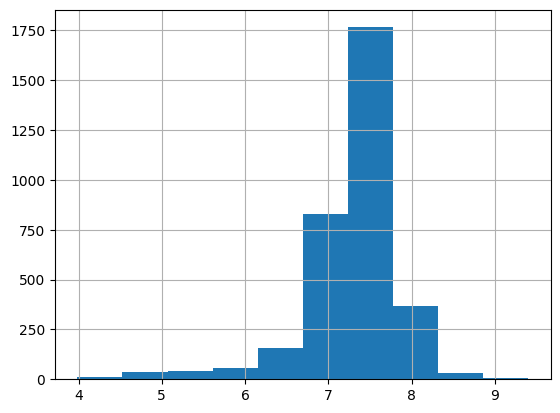

In [ ]:
pd.Series(scores).hist()

<Axes: >

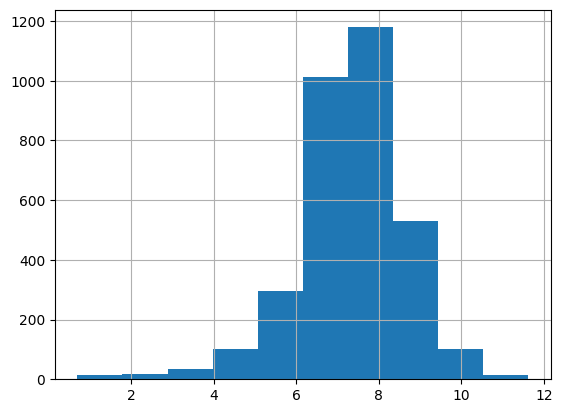

In [ ]:
y_test.hist()

### Writing model to GCS

In [ ]:
storage_client = storage.Client()

bucket = storage_client.bucket(project)
blob = bucket.blob('catboost_model.pickle')

pickle_out = pickle.dumps(my_model)
blob.upload_from_string(pickle_out)